In [25]:
from sklearn.cross_validation import train_test_split
from sklearn import datasets

from scipy.linalg import solve
from scipy.sparse import linalg, eye
from scipy import stats
from scipy.spatial import distance

import matplotlib.pyplot as plt
import numpy as np

In [26]:
# chargement 
digits = datasets.load_digits()
x = digits.data
y = digits.target

# split data
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.1)


In [27]:
def distance_between_points(X):
    '''euclidian distance'''
    N,M = X.shape
    
    X2 = np.sum(X**2,1)
    res_1 = np.zeros((N,N))
    res_2 = np.zeros((N,N))
    
    for i in range(N):
        res_1[i,:] = X2
        res_2[:,i] = X2.T
    
    distance = res_1 + res_2 - 2*X.dot(X.T)
    
    return distance

def neighbors (Matrix_distance,k):

    Matrix_Distance_argsorted = np.argsort(Matrix_distance)
    res = Matrix_Distance_argsorted[:,1:k+1]
    
    return res

In [28]:
class MyLLE():
    '''Locally Linear Embedding'''
    
    def __init__(self,n_components=2,n_neighbors=5):
        self.n_components = n_components
        self.n_neighbors = n_neighbors
    
    def fit_transform(self,X):
        '''Transform Initial Vectors to #n_components vectors'''
        # calcule des weights 
        #N number of samples
        #M number of features
        N,M = X.shape

        #Matrix of Distance
        D = distance_between_points(X)

        #Nearest Neighbors
        Matrix_Neighbors_index = neighbors(D,self.n_neighbors)

        #Initialisation des poids pour les n_neighbors
        W = np.zeros((N,self.n_neighbors))
        
        #Initialisation de tous les poids 
        WW = np.zeros((N,N))
        
        point = np.zeros((self.n_neighbors,M))
        voisins = np.zeros((self.n_neighbors,M))
        
        #Calculate weights for each points
        for ii in range(N):

            # le point original repeter k fois 
            for i in range(self.n_neighbors):

                point[i,:] = X[ii,:] 

            # les voisins du point original     
            for j in range(self.n_neighbors):

                kk = Matrix_Neighbors_index[ii][j]
                voisins[j,:] = X[kk,:]

            z = point - voisins  
            A = z.dot(z.T)   
            B = np.ones(self.n_neighbors)
            W[ii,:] = solve(A,B)       #  solve Aw=B
            W[ii,:] = W[ii,:]/np.sum(W[ii,:])    
            WW[ii][Matrix_Neighbors_index[ii]] = W[ii]

        M = np.identity(N)-WW
        matrice = M.T.dot(M) 
        u,sigma,v = np.linalg.svd(matrice,full_matrices=0)
        indice = np.argsort(sigma)[1:4]
        self.X = np.array(v[indice,:].T) 

        return self.X

In [29]:
class MyTSNE():
    '''MyTSNE'''
    def __init__(self,perp, nIter, lr, moment, dim=2,debug=False):
        self.perp = perp # entre 5 et 50
        self.nIter = nIter
        self.lr = lr
        self.moment = moment
        self.dim = dim 
        self.debug = debug
        
    def fit_transform(self,data):
        nEx = np.shape(data)[0]
        # Matrice des distances de ||xi - xj||² #
        normx = np.sum(data**2,1)
        normx = np.reshape(normx, (1, nEx))
        distancex = normx + normx.T - 2 * data.dot(data.T)
        # Calcul des sigma 
        lperp = np.log2(self.perp)
        # initialisation bornes pour la recherche dichotomique #
        sup = np.ones((nEx,1)) * np.max(distancex)
        inf = np.zeros((nEx,1))
        self.sigma = (sup + inf) / 2.
        
        # recherche dichotomique
        while True:
            # Calculer la matrice des p(i|j)
            self.pcond = np.exp(-distancex / (2. * (self.sigma**2)))
            self.pcond = self.pcond / np.sum(self.pcond - np.eye(nEx),1).reshape(nEx,1)
            # Calculer l'entropie de p(i|j)
            entropy = - np.sum(self.pcond * np.log2(self.pcond), 0)
            # Mise a jour des bornes
              # Si il faut augmenter sigma
            up = entropy < lperp 
            inf[up,0] = self.sigma[up,0]
              # Si il faut baisser sigma
            down = entropy > lperp 
            sup[down,0] = self.sigma[down,0]
            # Mise a jour de sigma et condition d'arrêt
            old = self.sigma
            self.sigma = ((sup + inf) / 2.)
            if np.max(np.abs(old - self.sigma)) < 1e-5:
                break
        
        #initialiser y
        self.embeddings = np.zeros((self.nIter+2, nEx, self.dim))
        self.embeddings[1] = np.random.randn(nEx, self.dim) * 1e-4
        
        # p(ij)
        self.pij = (self.pcond + self.pcond.T) / (2.*nEx)
        np.fill_diagonal(self.pij, 0)
        
        # Descente de Gradient
        loss = []
        for t in range(1,self.nIter+1):
            # Matrice des distances 
            normy = np.sum((self.embeddings[t]**2),1)
            normy = np.reshape(normy, (1, nEx))
            distancey = normy + normy.T - 2 * self.embeddings[t].dot(self.embeddings[t].T)
            
            self.qij = 1 / (1 + distancey)
            np.fill_diagonal(self.qij, 0)
            self.qij = self.qij / self.qij.sum()
            
            yt = self.embeddings[t]
            tmpgrad = 4 * ((self.pij - self.qij) / (1 + distancey)).reshape(nEx, nEx,1)
            for i in range(nEx):
                dy = (tmpgrad[i] * (yt[i]-yt)).sum(0)
                self.embeddings[t+1][i] = yt[i] - self.lr * dy + self.moment * (yt[i] - self.embeddings[t-1,i])
            l = stats.entropy(self.pij, self.qij, 2).mean()
            loss.append(l)
            if self.debug and t % 20 == 0:
                print t,l
        return self.embeddings[-1,:,:]

In [30]:
def plot_new_embedding(Y,Y_train):
    
    fig = plt.figure()
    labels = Y_train
    colormap = np.array(['r', 'g', 'b','#16B84E','y','#87591A','c','m','#FF00FF','#D473D4'])
    plt.scatter(Y[:,0], Y[:,1]  , c=colormap[labels])
    plt.show()

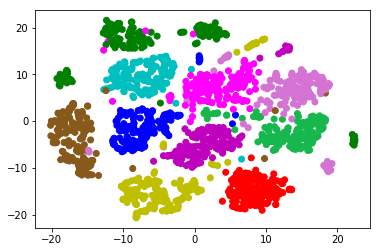

In [31]:
data = datasets.load_digits()
My_TSNE = MyTSNE(5,300,1000,0)
X_tsne = My_TSNE.fit_transform(data.data)
plot_new_embedding(X_tsne, data.target)

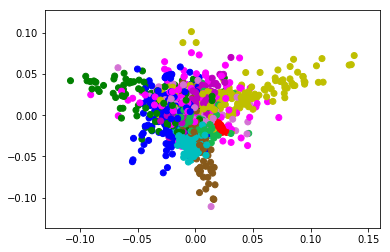

In [32]:
My_LLE = MyLLE(n_neighbors=20)
X_LLE = My_LLE.fit_transform(X_train)

plot_new_embeding(X_LLE,Y_train)

In [33]:
from sklearn import manifold

In [34]:
sklearn_LLE = manifold.LocallyLinearEmbedding(n_neighbors=20)
sklearn_TSNE = manifold.TSNE()

In [35]:
X_sklearn_LLE = sklearn_LLE.fit_transform(X_train)
X_sklearn_TSNE = sklearn_TSNE.fit_transform(X_train)

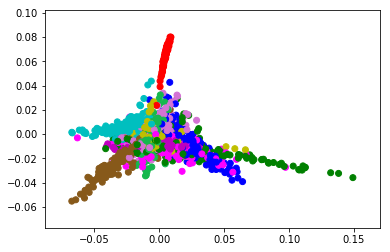

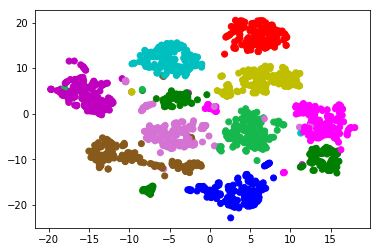

In [36]:
plot_new_embeding(X_sklearn_LLE,Y_train)
plot_new_embeding(X_sklearn_TSNE,Y_train)